In [1]:
# https://www.geeksforgeeks.org/ml-implementing-l1-and-l2-regularization-using-sklearn/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from statistics import mean

# extra added so can use RMSE instead of R-squared
from sklearn.metrics import mean_squared_error

RANDOMSTATE = 75

# loading teh data into a pandas dataframe
data = pd.read_csv('..\data\kc_house_data.csv')

data.shape

(21613, 21)

In [2]:
# dropping the numerically non-sensical variables
dropColumns = ['id','date','zipcode']
data = data.drop(dropColumns, axis = 1)
data = data.dropna()
data.head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180.0,0,1955,0,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170.0,400,1951,1991,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770.0,0,1933,0,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050.0,910,1965,0,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680.0,0,1987,0,47.6168,-122.045,1800,7503
5,1225000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890.0,1530,2001,0,47.6561,-122.005,4760,101930
6,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715.0,0,1995,0,47.3097,-122.327,2238,6819
7,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060.0,0,1963,0,47.4095,-122.315,1650,9711
8,229500.0,3,1.00,1780,7470,1.0,0,0,3,7,1050.0,730,1960,0,47.5123,-122.337,1780,8113
9,323000.0,3,2.50,1890,6560,2.0,0,0,3,7,1890.0,0,2003,0,47.3684,-122.031,2390,7570


In [3]:
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,2.161100e+04,21611.000000,21611.000000,21611.000000,2.161100e+04,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000
mean,5.400850e+05,3.370830,2.114791,2079.853454,1.510771e+04,1.494332,0.007542,0.234325,3.409421,7.656888,1788.396095,291.457360,1971.007959,84.410069,47.560046,-122.213894,1986.559576,12769.025357
std,3.671430e+05,0.930092,0.770157,918.422406,4.142235e+04,0.540003,0.086521,0.766350,0.650755,1.175502,828.128162,442.487355,29.372358,401.697007,0.138568,0.140831,685.416548,27305.369808
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.217250e+05,3.000000,1.750000,1426.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.470950,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068850e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.500000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


In [4]:
data.shape[0] # confirm removed rows of NAN

21611

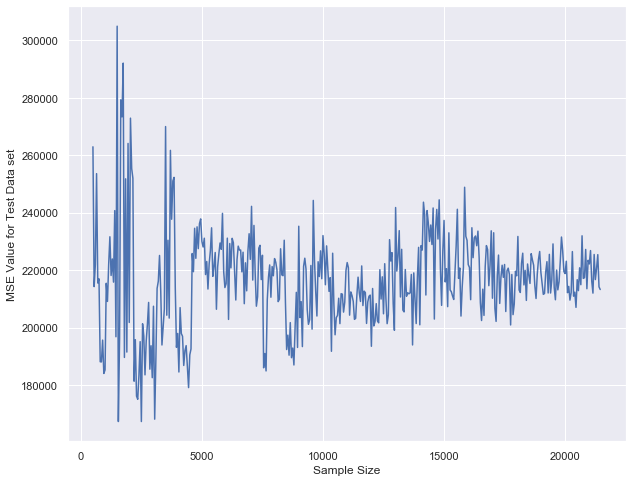

In [24]:
# list to maintain different sample fractions
sampleSize = []

# list to maintain differenve values of fit
fitScore = []

# for i in range(1,200):
#    dataA = data.sample(frac = i / 2 / 100, random_state = 5)

for i in range(10,430):
    dataA = data.sample(n = i*50, random_state = RANDOMSTATE)
    
    # separating dependent and independent variables
    y = dataA['price']
    X = dataA.drop('price', axis = 1)
    
    # dividing the data into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = 0.25,
        random_state = RANDOMSTATE
    )

    # building and fitting the linear regression model
    linearModelA = LinearRegression()
    linearModelA.fit(X_train, y_train)

    # modified code so that it will use RMSE instead of R-squared
    #fitScoreInt = linearModelA.score(X_test,y_test)
    y_pred = linearModelA.predict(X_test)
    fitScoreInt = np.sqrt(mean_squared_error(y_test,y_pred))
    
    sampleSizeInt = dataA.shape[0]
    sampleSize.append(sampleSizeInt)
    
    fitScore.append(fitScoreInt)
    
# loop to print the different values scores and training data
# for i in range(0, len(sampleSize)):
#     print(str(sampleSize[i]) + ' : ' + str(fitScore[i]))

plt.xlabel('Sample Size')
plt.ylabel('MSE Value for Test Data set')
plt.plot(sampleSize,fitScore)

In [14]:
# list to maintain different sample fractions
sampleSize2 = []

# list to maintain differenve values of fit
fitScore2 = []

# list to maintain test fraction size
testSize2 = []

# for i in range(1,200):
#    dataA = data.sample(frac = i / 2 / 100, random_state = 5)

for i in range(10,430):
    dataB = data.sample(n = i*50, random_state = RANDOMSTATE)
    
    # separating dependent and independent variables
    y = dataB['price']
    X = dataB.drop('price', axis = 1)

    for j in range(2,5):
        # dividing the data into training and testing set
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            test_size = 1/j,
            random_state = RANDOMSTATE
        )

        # building and fitting the linear regression model
        linearModelB = LinearRegression()
        linearModelB.fit(X_train, y_train)
        
        # modified code so that it will use RMSE instead of R-squared
        #fitScoreInt = linearModelA.score(X_test,y_test)
        y_pred = linearModelB.predict(X_test)
        fitScoreInt = np.sqrt(mean_squared_error(y_test,y_pred))
        
        sampleSizeInt = dataB.shape[0]
        sampleSize2.append(sampleSizeInt)

        fitScore2.append(fitScoreInt)
        
        testSize2.append(1/j)
    
# loop to print the different values scores and training data
# for i in range(0, len(sampleSize)):
#     print(str(sampleSize[i]) + ' : ' + str(fitScore[i]))

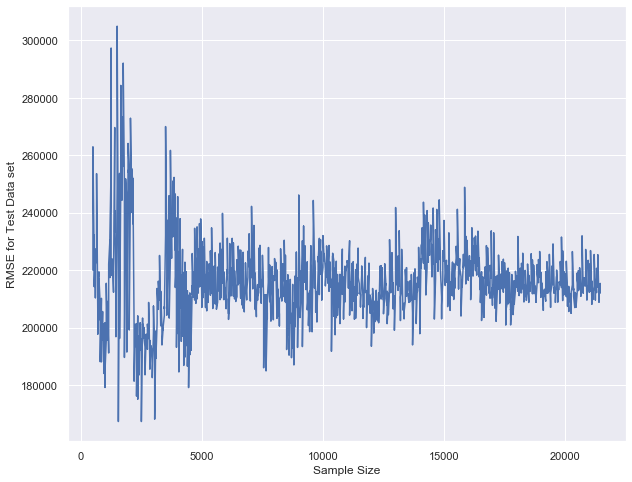

In [15]:
plt.xlabel('Sample Size')
plt.ylabel('RMSE for Test Data set')
plt.legend
plt.plot(sampleSize2,fitScore2)

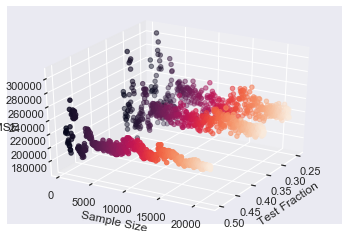

In [16]:
from mpl_toolkits import mplot3d
%matplotlib inline

col = np.arange(1260)

fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.scatter3D(testSize2,sampleSize2, fitScore2,c = col)
ax.set_xlabel('Test Fraction')
ax.set_ylabel('Sample Size')
ax.set_zlabel('RMSE')
ax.view_init(30,30)

In [19]:
dataSet = pd.DataFrame({
    'Sample Size' : sampleSize2,
    'RMSE' : fitScore2,
    'Test fraction' : testSize2}
)
dataSet['Test fraction Color'] = dataSet['Test fraction'] * 60
dataSet['Test fraction (rounded)'] = dataSet['Test fraction'].round(decimals=2)
dataSet.tail()

,Sample Size,RMSE,Test fraction,Test fraction Color,Test fraction (rounded)
1255,21400,211432.927381,0.333333,20.0,0.33
1256,21400,214211.175743,0.250000,15.0,0.25
1257,21450,212014.170807,0.500000,30.0,0.50
1258,21450,215355.027690,0.333333,20.0,0.33
1259,21450,213270.867173,0.250000,15.0,0.25


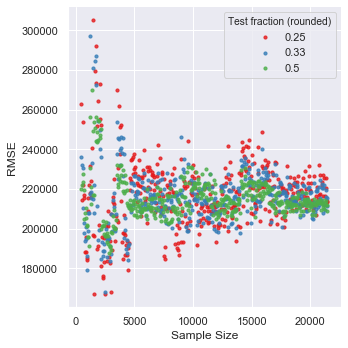

In [20]:
# load library
import seaborn as sns

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize': (10,8)})

# use the aplette argument
sns.lmplot(
    x = "Sample Size",
    y = "RMSE",
    data = dataSet,
    fit_reg = False,
    hue = 'Test fraction (rounded)',
    legend = "full",
    palette = "Set1",
    scatter_kws={"s":10},
    legend_out = False
)

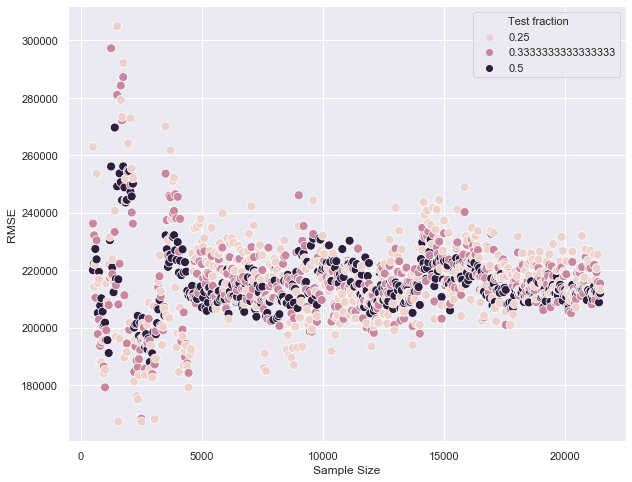

In [36]:
cmap = sns.cubehelix_palette(dark = 0.3, light = 0.5, as_cmap = True)
ax = sns.scatterplot(
    x = "Sample Size",
    y = "RMSE",
    hue = "Test fraction",
    data = dataSet,
    legend = "full",
    s=80
)

fig = ax.get_figure()
fig.savefig('myfigure.png')

In [22]:
# separating dependent and independent variables
y = data['price']
X = data.drop('price', axis = 1)

# dividing the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.25,
    random_state = RANDOMSTATE
)

# building and fitting the linear regression model
linearModelC = LinearRegression()
linearModelC.fit(X_train, y_train)
fitScoreInt = linearModelC.score(X_test,y_test)

linearModelC.intercept_

-37249536.215752944

In [23]:
linearModelB.coef_

array([-3.30851249e+04,  4.16739351e+04,  1.07302114e+02,  1.11661747e-01,
       -1.42744114e+03,  6.02608951e+05,  4.53819214e+04,  2.95709792e+04,
        9.72013239e+04,  7.15549374e+01,  3.57471762e+01, -2.43656283e+03,
        2.17928550e+01,  5.57142023e+05, -1.18968019e+05,  2.77934681e+01,
       -3.36242730e-01])